### Kaggle's Dog Breed Identification Competition
   - Determine the breed of a dog in an image
       -   https://www.kaggle.com/competitions/dog-breed-identification/overview
  
    
### Objective:
You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. 

### Evaluation 
 - Kaggle's evaluation metric: Multi Class Log Loss 
 - Evaluation file has prediction probabilities for each dog breed of each test image
 
### Features
 - Unstructured Data (images)
 - Multiclass Classification (120 labels)
 - Train data 10,000+  images (with labels)
 - Test data 10,000+  images 

## Experiment Steps

- Preprocess image data 
- Choose a deep learning model
- Fit model to the data  
- Evaluate model performance
- Make predictions using model
- Save and load model
- Use best trained model to make predictions on custom data

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import os
import datetime
%load_ext tensorboard
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Getting Data Ready  


### Labels 

In [18]:
train_labels_df = pd.read_csv("dog-breed-identification/labels.csv")
train_labels_df.describe()
train_labels_df

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

#### Observation: 
  - 10222 labels with 120 unique breeds

## Labels Distribution

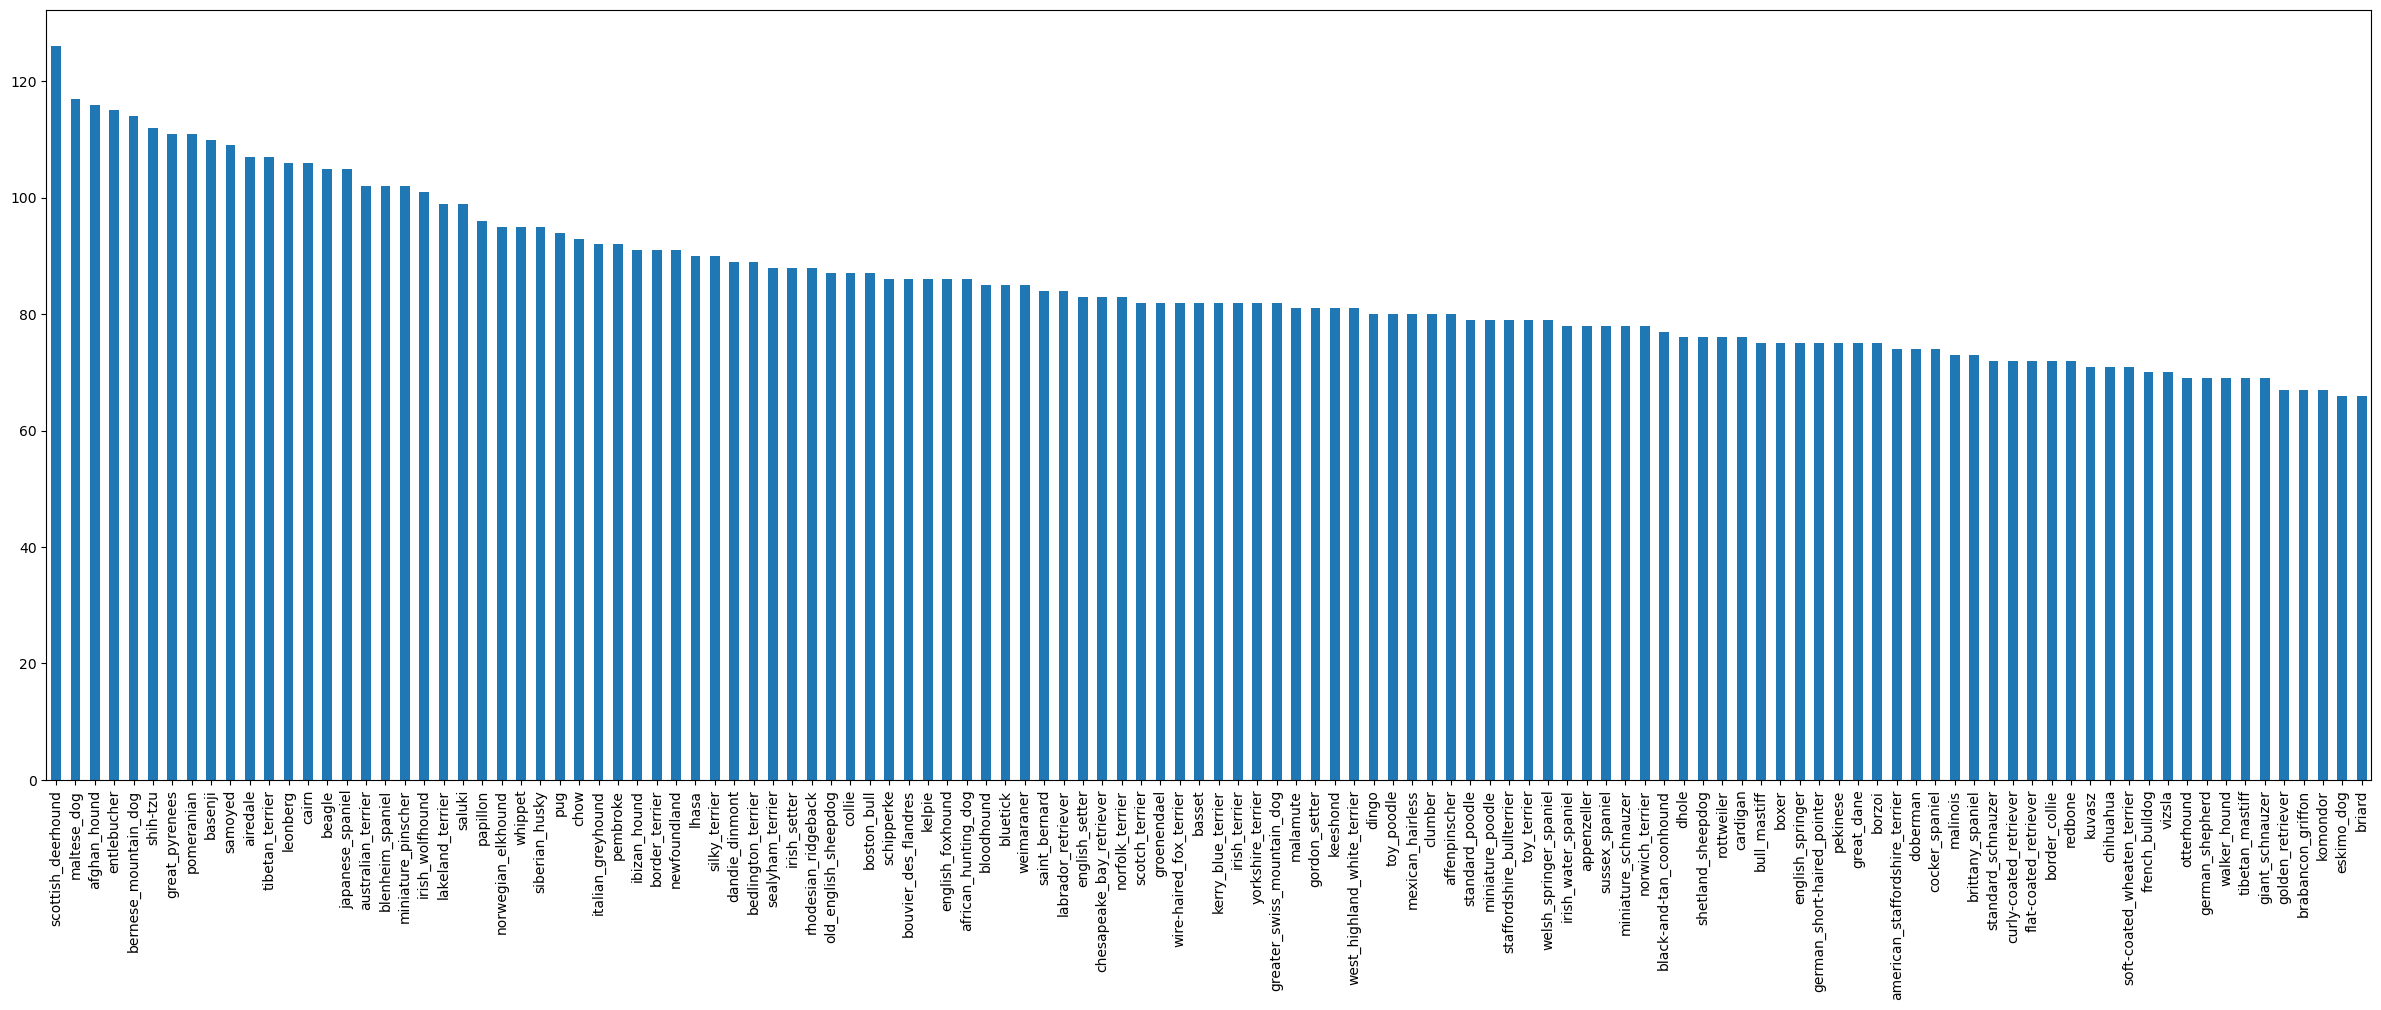

In [19]:
train_labels_df.breed.value_counts().mean()
train_labels_df.breed.value_counts().median()
train_labels_df.breed.value_counts().plot.bar(figsize = (30,10));

#### Observation: 
- Distribution of images per class/dog breed is relatively even

### Lists of Image's filepaths
- train_file_paths
- test_file_paths


In [20]:
train_dir = "dog-breed-identification/train/"
train_file_paths = [train_dir+file+".jpg" for file in train_labels_df.id]

In [21]:
test_dir = "dog-breed-identification/test/"
test_files = os.listdir(test_dir)
test_file_paths=[test_dir+ i for i in test_files]

### View random images from Train Directory

- Create a function to view random Train images and labels

In [22]:
def random_train_image():
    
    '''
    Displays Random image from train files
    '''
    
    train_dir = "dog-breed-identification/train/"
    files = train_labels_df.id
    file = random.choice(files)
    img_title = np.array(train_labels_df.breed[train_labels_df.id == file])

    fig, ax = plt.subplots(figsize = (10,5))
    ax.imshow(plt.imread(train_dir+file+".jpg"))
    ax.set(title=img_title[0]);
    ax.axis(False);


### One hot encode labels
- turn them into booleans 

In [23]:
labels = np.array(train_labels_df.breed)
unique_labels = np.unique(labels)

In [24]:
boolean_labels = []
for label in labels:
    boolean_labels.append(label == unique_labels)

## Split train set into Train and Validation set 

- use one tenth of the available data to begin training 
    - assign 20% of the one tenth to validation data

In [25]:
>>> from sklearn.model_selection import train_test_split


X = train_file_paths[:1000]
y = boolean_labels[:1000]

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                   y, 
                                                   test_size=0.20, 
                                                   random_state=42)    


## Processing Images

Create a function takes filepath as input makes the following changes
- uses tensorflow to read the image 
- turn it into an interger tensor
- resize to be a shape of (224,224)
- return the modified image

In [26]:
def process_x(image_path):
    
    '''
    takes an image's file path and converts it into a tensor
    
    '''
    
    image = tf.io.read_file(image_path) 
    #reads an image file path

    image = tf.image.decode_jpeg(image, 3) 
    #turns image into a numerical tensor with 3 color channels

    image = tf.image.convert_image_dtype(image, tf.float32)
    #scales the tensor values

    image = tf.image.resize(image, size = [224, 224])
    #resizes the tensor to shape (224, 224, 3)

    return image

## Processing Images and labels
Create a preprocessing function that 
- takes in image_path and label
- returns image and label in tensors and in Tuple format

In [27]:
def process_x_y (image_path, label):
    
    '''
     Takes in image_path and label,
     returns image as numerical tensor with label in tuple format
    
    '''
    image = process_x(image_path) #transforms X to numerical tensor
    return image, label #returns (x,y) in tuple format2
    

## Key note: 
In order to train model, data has to be
- In a tuple format dataset
    - in tensors - X as numerical
    - shuffled
    - in batches
    


## Preprocesing Function

- create a preprocessing function that returns dataset after formatting data to meet model requirements depending on dataset type 
 

In [28]:
def data_preprocessing(X, y, train_data = False, validation_data = False, test_data = False):
    '''
    Takes data as inputs and returns dataset 
    after formatting data to meet model requirements 
    depending on data type
    '''
    
    if train_data:
        
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))                                           
        data = data.shuffle(buffer_size = len(data))
        data = data.map(process_x_y) 
        data = data.batch(batch_size=32)

    elif validation_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.map(process_x_y).batch(32)
    
    elif test_data:   
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        data = data.map(process_x).batch(32)

        
    return data
       


In [29]:
data_train = data_preprocessing(X_train, y_train, train_data = True)
data_val = data_preprocessing(X_val, y_val, validation_data = True)

## Visualizing Data 
- Create a function to visualize test or validation data

In [30]:
def visualize_data(validation_data= False):
    
    '''
    Displays images of specified train or validation data.
    
    '''
    
    if validation_data:
        images, labels = next(data_val.as_numpy_iterator())
    else:
        images, labels = next(data_train.as_numpy_iterator())
   
    plt.figure(figsize=(15,15))
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i])
        plt.title(unique_labels[np.argmax(labels[i])].upper())
        ax.set_xticks([])
        ax.set_yticks([])
    
    

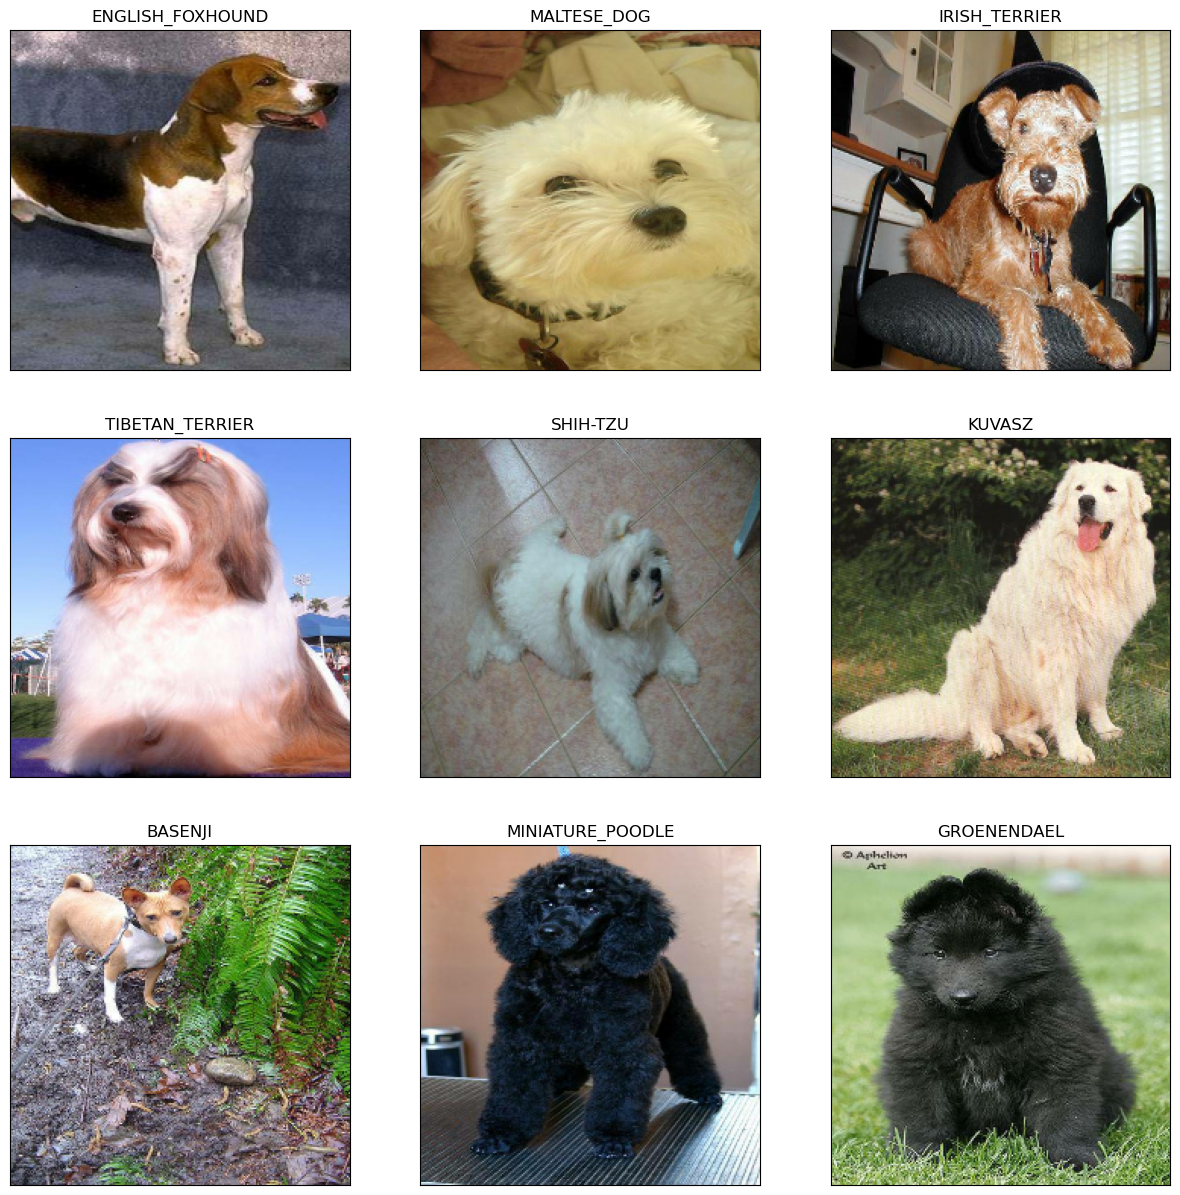

In [31]:
visualize_data(validation_data=False)

# Build Model
- Using Pretrained Model, mobilenet_v2_130_224

### key_note:
- mobilenet_v2_130_224 has a batch input shape of [None, 224, 224, 3]
 - the data's input shape has to match with mobilenet's input shape

In [33]:
input_shape = [None, 224, 224, 3]
output_shape = (len(unique_labels))
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


### Functionize  Model Creation
- Create a function that builds and compiles a model with parameters
    - input_shape, output_shape, model_url

In [44]:
def create_and_compile_model (input_shape = input_shape, output_shape=output_shape, model_url = model_url):

    
    '''
    creates model using pretrained model mobilenet_v2 from tensorflow hub
    '''
    
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url, 
                       name = ("pretrained_model")),
        tf.keras.layers.Dense(output_shape,
                              activation = "softmax",
                              name = ("output_layer"))
    ])
    
    model.compile(loss = tf.keras.losses.categorical_crossentropy,
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics="accuracy"
    )
    
    model.build(input_shape) #to use mobilenet, model has to be built with this shape
    
    print(f'Building model using pretatined model {model_url}')
    
    
    return model

### Create and Compile Model 

In [45]:
model = create_and_compile_model(input_shape, output_shape, model_url)

Building model using pretatined model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pretrained_model (KerasLaye  (None, 1001)             5432713   
 r)                                                              
                                                                 
 output_layer (Dense)        (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Tensorboard callback
   - create function for creating Tensorboard callback to monitor model performance

In [47]:
def create_tensorboard_callback(tensorboard_dir):
    
    '''creates and returns tensorboard callback to specified directory'''
    
    logdir = os.path.join(tensorboard_dir,
                    datetime.datetime.now().strftime("%m%d%Y -%H%M$S"))
    
    #log dir stores information in the given dir witg the formatted time
    
    return tf.keras.callbacks.TensorBoard(logdir)
            

### Model Training with Callbacks

- create a function that trains and validates given model on given data with callbacks Tensorboard and Early stopping
    

In [50]:
def train_model(model, epochs, train_data, tensorboard_dir, early_stopping_monitor_metric, val_data = None):
    
    '''
    Trains and validates model, stores model performance and monitors metric for early stopping.
    Returns model and model history
    '''

    
    
    #create instance of tensorboard
    tensorboard = create_tensorboard_callback(tensorboard_dir=tensorboard_dir)

    
    #create early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=early_stopping_monitor_metric,
                                                 patience=3
                                                 )
    
    
    if val_data: #if validation data is assigned, train and validate model
    
        model_history =  model.fit(train_data,
                                  epochs=epochs, 
                                  steps_per_epoch= len(train_data),
                                  callbacks=[tensorboard, early_stopping],
                                  validation_data=val_data,
                                  validation_steps=len(val_data)                                           
    )
        
    else: 
        
        model_history =  model.fit(train_data,
                                  epochs=epochs, 
                                  steps_per_epoch= len(train_data),
                                  callbacks=[tensorboard, early_stopping]
                                                                           
    )
        
        
    return model, model_history


### Train Model 

In [49]:
model, model_history = train_model(model=model, 
                                       epochs=20, 
                                       train_data= data_train,
                                       val_data=data_val,
                                       tensorboard_dir="model_logs",
                                       early_stopping_monitor_metric ="val_accuracy")

Epoch 1/20
25/25 [==============================] - 15s 511ms/step - loss: 4.5223 - accuracy: 0.0913 - val_loss: 3.5756 - val_accuracy: 0.2300
Epoch 2/20
25/25 [==============================] - 12s 499ms/step - loss: 1.6125 - accuracy: 0.6963 - val_loss: 2.2285 - val_accuracy: 0.5300
Epoch 3/20
25/25 [==============================] - 13s 508ms/step - loss: 0.5632 - accuracy: 0.9350 - val_loss: 1.7461 - val_accuracy: 0.5800
Epoch 4/20
25/25 [==============================] - 12s 498ms/step - loss: 0.2503 - accuracy: 0.9950 - val_loss: 1.5434 - val_accuracy: 0.6400
Epoch 5/20
25/25 [==============================] - 12s 498ms/step - loss: 0.1444 - accuracy: 0.9975 - val_loss: 1.4734 - val_accuracy: 0.6350
Epoch 6/20
25/25 [==============================] - 12s 499ms/step - loss: 0.0984 - accuracy: 1.0000 - val_loss: 1.4323 - val_accuracy: 0.6250
Epoch 7/20
25/25 [==============================] - 12s 496ms/step - loss: 0.0746 - accuracy: 1.0000 - val_loss: 1.3970 - val_accuracy: 0.6400

### View Model Performance

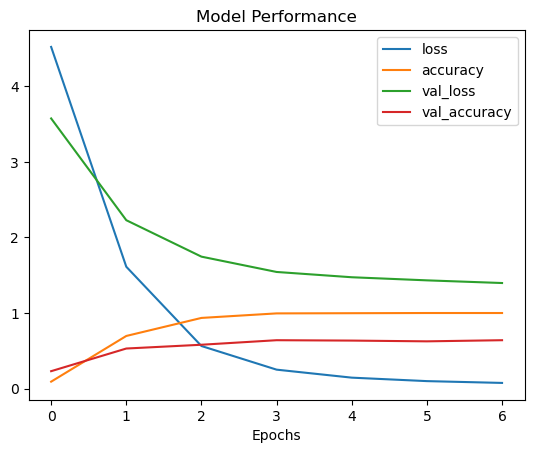

In [359]:
pd.DataFrame(model_history.history).plot(title = "Model Performance");
plt.xlabel("Epochs");
 

### Observations:
 - Model stopped short due to early stopping. 
 - Model is overfitting.
     - Its performing very well on train data but struggling on validation data
  

## Make predictions
- Use trained model to make predictions on validation data

In [55]:
predictions_val = model.predict(data_val)
evaluation_val = model.evaluate(data_val)         

7/7 [==============================] - 2s 335ms/step - loss: 1.3970 - accuracy: 0.6400


### Unbatching Data
Create a function that unbatches given dataset and returns 
- images in the form of arrays
- labels as breed name

In [129]:
def data_unbatching(dataset):

    images = []
    labels = []

    for image, label in dataset.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    
    return images, labels


### Compare Predicted label with True Label

Create a function that 
- plots an image, 
- title shows predicted labels, confidence interval, and true label

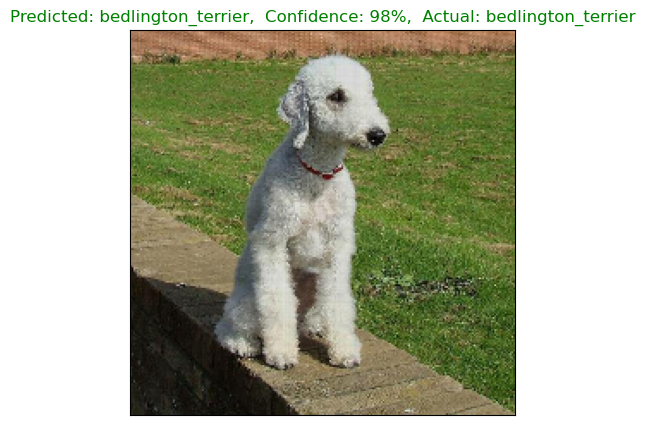

In [334]:
 def compare_predictions():

    '''
    
    Visualize model's predicted label, true label and prediction confidence of random image from validation data
    
    '''
    n = random.choice(range(len(predictions_val)-1))

    
    images, labels = data_unbatching(data_val)
 
    true_breed = unique_labels[np.argmax(labels[n])]
    max_pred_prob = round(max(predictions_val[n])*100)
    predicted_breed = unique_labels[np.argmax(predictions_val[n])]
    
    if true_breed == predicted_breed:
        color = "green"
    else:
        color = "red"

    fig, ax = plt.subplots(figsize= (5,5))
    plt.imshow(images[n]),
    plt.title("Predicted: {},  Confidence: {}%,  Actual: {}".format(predicted_breed, max_pred_prob,true_breed),color= color)
    ax.set_xticks([])
    ax.set_yticks([]);
    

    
compare_predictions()


###  Prediction Probabilities 
- Create a function that shows the model's top 10 predictions in a bar graph

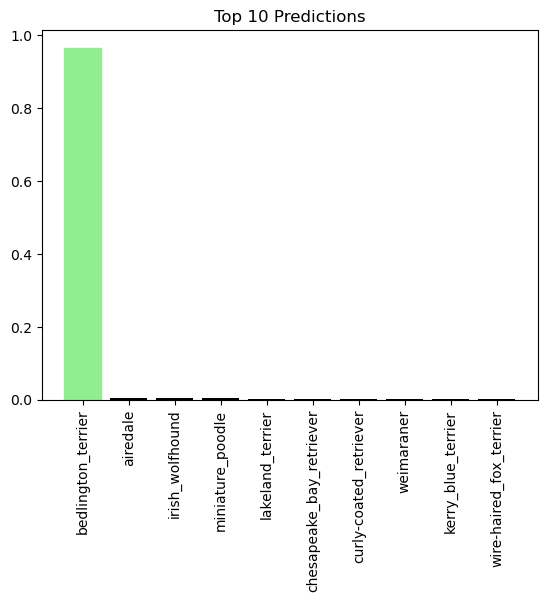

In [347]:

def view_pred_prob(index):
    
    '''
    view model's top ten predictions and probailities in a bar graph from a given 
    index within valdation data
    '''
    
    if index: # if index is given
        n = index
    else: # display from random index
        n = random.choice(range(len(predictions_val)-1))

    images, labels = data_unbatching(data_val)
    true_label = unique_labels[np.argmax(labels[n])]
    predicted_label = unique_labels[np.argmax(predictions_val[n])]


    sorted = np.argsort(predictions_val[n])[-10:][::-1]
    sorted_labels = unique_labels[sorted]

    predicted_probs = predictions_val[n]
    predicted_probs_top_10 = predicted_probs[sorted] 

    top_plot = plt.bar(sorted_labels, predicted_probs_top_10, color = "black");
    plt.xticks(rotation = "vertical" );
    plt.title("Top 10 Predictions")
 
    if true_label in sorted_labels: 
        top_plot[np.argmax([true_label == sorted_labels])].set_color("lightgreen");
        

        
view_pred_prob(5);


## Train Model on 90% Data

In [176]:
X = train_file_paths
y = boolean_labels


X_train, X_val, y_train, y_val = train_test_split(X, 
                                                   y, 
                                                   test_size=0.10, 
                                                   random_state=42)    

train_data = data_preprocessing(X=X_train, y=y_train, train_data=True)

val_data = data_preprocessing(X=X_val, y=y_val, validation_data=True)


### Create and Train Model 2

In [179]:
model_2 = create_and_compile_model()
model_2, model_2_history = train_model(model_2,
                                             epochs=30, 
                                             train_data=train_data,
                                             val_data= val_data,
                                             tensorboard_dir="model_2_logs", 
                                             early_stopping_monitor_metric ="val_accuracy")



Building model using pretatined model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/30
288/288 [==============================] - 129s 437ms/step - loss: 1.4181 - accuracy: 0.6576 - val_loss: 0.7040 - val_accuracy: 0.7830
Epoch 2/30
288/288 [==============================] - 124s 432ms/step - loss: 0.4058 - accuracy: 0.8799 - val_loss: 0.6599 - val_accuracy: 0.8016
Epoch 3/30
288/288 [==============================] - 125s 433ms/step - loss: 0.2359 - accuracy: 0.9371 - val_loss: 0.6328 - val_accuracy: 0.8084
Epoch 4/30
288/288 [==============================] - 126s 437ms/step - loss: 0.1527 - accuracy: 0.9670 - val_loss: 0.6567 - val_accuracy: 0.8104
Epoch 5/30
288/288 [==============================] - 126s 439ms/step - loss: 0.1024 - accuracy: 0.9807 - val_loss: 0.6644 - val_accuracy: 0.8104
Epoch 6/30
288/288 [==============================] - 126s 438ms/step - loss: 0.0742 - accuracy: 0.9884 - val_loss: 0.6872 - val_accuracy: 0.8074
Epoch 7/30
288

### Evaluate Model 2

In [180]:
model_2.evaluate(val_data)

32/32 [==============================] - 13s 401ms/step - loss: 0.6936 - accuracy: 0.8094


[0.6935993432998657, 0.8093841671943665]

### View Model 2 Performance

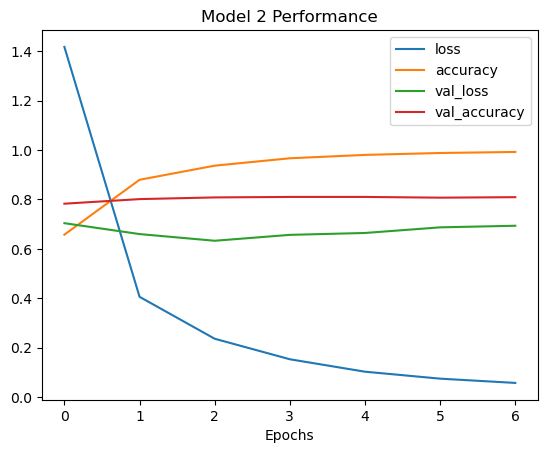

In [360]:
pd.DataFrame(model_2_history.history).plot(title = "Model 2 Performance");
plt.xlabel("Epochs");
 

### Observations:
 - Model 2 stopped short due to early stopping. 
 - Model 2 is overfitting but yielding better results due to more training data.
  

## Train Model on Full Data

In [348]:
X = train_file_paths
y = boolean_labels

train_data_full = data_preprocessing(X, y, train_data=True)

### Create and Train Model 3

In [190]:
model_3 = create_and_compile_model()
model_3, model_3_history = train_model(model_3,
                                     epochs=30, 
                                     train_data=train_data_full,
                                     tensorboard_dir="model_3_logs", 
                                     early_stopping_monitor_metric ="accuracy")



Building model using pretatined model https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/30
320/320 [==============================] - 130s 398ms/step - loss: 1.3326 - accuracy: 0.6723
Epoch 2/30
320/320 [==============================] - 164s 512ms/step - loss: 0.3995 - accuracy: 0.8842
Epoch 3/30
320/320 [==============================] - 127s 395ms/step - loss: 0.2387 - accuracy: 0.9360
Epoch 4/30
320/320 [==============================] - 127s 397ms/step - loss: 0.1548 - accuracy: 0.9632
Epoch 5/30
320/320 [==============================] - 126s 395ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 6/30
320/320 [==============================] - 127s 398ms/step - loss: 0.0772 - accuracy: 0.9858
Epoch 7/30
320/320 [==============================] - 127s 396ms/step - loss: 0.0582 - accuracy: 0.9923
Epoch 8/30
320/320 [==============================] - 129s 403ms/step - loss: 0.0457 - accuracy: 0.9944
Epoch 9/30
320/320 [==============================] - 126s

### View Model 3 Performance

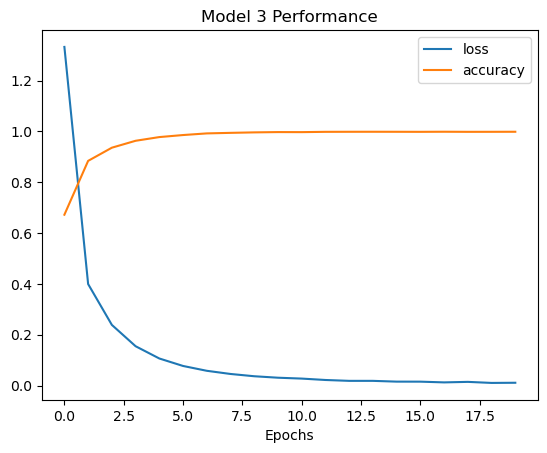

In [350]:
pd.DataFrame(model_3_history.history).plot(title = "Model 3 Performance");
plt.xlabel("Epochs");
 

### Observations:
 - Model 3 stopped short due to early stopping. 
 - Model 3 has yielded the highest accuracy due to training on full data.

### Save and Load Model 3 using SavedModel format

In [194]:
model_3.save(filepath="model_3_SavedModel_format")
loaded_model_3 = tf.keras.models.load_model("model_3_SavedModel_format")

INFO:tensorflow:Assets written to: model_3_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_3_SavedModel_format/assets


## Make Predictions Test Dataset
- preprocess test dataset
- predict on test dataset
- save predictions array in csv file

In [202]:
#Preprocess test dataset
data_test = data_preprocessing(test_file_paths, y = None, test_data=True)

#predict on test dataset
predictions_test = model_3.predict(data_test)

#save predictions array to csv file
np.savetxt("predictions/model_3_preds_array.csv",predictions_test, delimiter=",")


324/324 [==============================] - 110s 339ms/step


## Preparing File for Kaggle Submission
    
- Kaggle's sample submission is a csv file
    
   - Columns: 
     - picture id
     - unique breeds
    
   - Data: 
     - id names
     - prediction confidence for each breed

### Extract image id from image_file names

In [213]:
id_list = [path.split(".jpg")[0] for path in os.listdir(test_dir)]

### Create DF following Kaggle's Sample Submission file

In [220]:
test_predictions = pd.DataFrame(data = predictions_test,
            columns= list(unique_labels))

test_predictions.insert(0,"id", id_list)
test_predictions.head()

id  affenpinscher  afghan_hound  \
0  266490a2b053a4a3bf68e779f28fb5a9   5.228972e-09  2.774096e-06   
1  dae9fd18836d8df20989ef0101771d4b   5.414614e-03  2.614494e-04   
2  079a40f22b0fad9a66f76797b62bb930   4.854757e-08  4.296511e-11   
3  ab8462f9a501d362041d47582fddc9ad   5.167685e-10  5.740601e-09   
4  8895089b432e020cc42e6262b5a1c2dd   6.665808e-11  3.902830e-10   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         7.138956e-09  1.023460e-06                    4.666126e-12   
1         2.338480e-06  4.483364e-07                    1.317835e-07   
2         6.515513e-13  3.434683e-11                    2.405651e-11   
3         1.000889e-12  5.794151e-09                    2.585751e-12   
4         1.240750e-09  1.111778e-11                    1.044926e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.867759e-06        1.221639e-12  4.870531e-11  6.874145e-04  ...   
1  5.739817e-08        9.829003e-04  1.722839e-09  3.099312e-08  ...   
2  5.753555e-12        1.371143e-12  1.740382e-12  1.331748e-12  ...   
3  8.137624e-09        3.014521e-09  6.075264e-13  8.196295e-11  ...   
4  1.443813e-09        7.633906e-08  1.418263e-04  3.628165e-06  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.519991e-10  3.170159e-09  2.343661e-05  8.531338e-07  1.824063e-07   
1  3.782258e-07  2.277832e-07  1.145852e-08  2.439021e-05  7.118466e-05   
2  4.829486e-13  3.313883e-13  2.066518e-13  1.042168e-11  1.309253e-11   
3  2.469110e-09  1.689946e-11  5.785833e-10  9.953800e-09  6.897814e-11   
4  6.310955e-10  2.038065e-08  2.756773e-10  2.626364e-11  9.238033e-11   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            9.379582e-12                 2.274621e-09  1.067968e-05   
1            3.796916e-11                 1.869218e-06  3.131841e-06   
2            2.651746e-13                 5.852119e-14  7.680184e-13   
3            3.834695e-08                 5.102971e-10  9.480108e-11   
4            3.282594e-08                 1.530323e-08  1.986010e-08   

   wire-haired_fox_terrier  yorkshire_terrier  
0             6.912974e-11       3.405324e-12  
1             1.542001e-06       1.223199e-08  
2             7.569699e-13       8.192746e-13  
3             2.768317e-13       8.956601e-08  
4             8.301756e-09       2.886559e-12  

[5 rows x 121 columns]

### Export test_predictions to CSV file

In [219]:
test_predictions.to_csv("kaggle_submission_file/submission_file.csv",
                             index= False)

## Predict on Custom Images

In [362]:
def custom_image_prediction(image_dir):

    
    '''
    Takes a file of dog images, returns a data frame of Image ID's and Model's predictions and plots images with predictions as titles
    '''
    
    
    
    #creating file paths to custom images   
    custom_images = list(os.listdir(image_dir))
    
    if ".DS_Store" in custom_images:
        custom_images.remove(".DS_Store")

    custom_images_filepaths = [image_dir  +"/"+ name for name in custom_images]


    #preprocessing custom images
    data_custom_images = data_preprocessing(custom_images_filepaths, y= False, test_data=True)

    
    #predicting on custom images
    predictions_custom_images = model_3.predict(data_custom_images, verbose=False)


    #lists image id and model's prediction on image
    custom_images_id = [items.split(".jpeg")[0] for items in custom_images]
    predictions_custom_images_labels = [unique_labels[np.argmax(i)] for i in predictions_custom_images]

    #create a DF with columns image id & model's prediction
    custom_images_df = pd.DataFrame({"Image_ID": custom_images_id,
                                    "Prediction": predictions_custom_images_labels})
    
    
    
    custom_images_tensors = []
    
    
    #unbatch and loop through custom images
    for items in data_custom_images.unbatch().as_numpy_iterator():
        custom_images_tensors.append(items)
    
    plt.figure(figsize=(15,20))
    for num, image in enumerate(custom_images_tensors):
        
        if len(custom_images_tensors) % 2 == 0:
 
            plt.subplot(int(len(custom_images_tensors)/2), 2, num+1)
        else:
 
            plt.subplot(len(custom_images_tensors), 1, num+1)

        
        plt.xticks([])
        plt.yticks([])
        plt.title(predictions_custom_images_labels[num].upper())
        plt.imshow(image)
    
    
    return custom_images_df





Image_ID        Prediction
0        Rottweiler        rottweiler
1        Pomeranian        pomeranian
2             Husky        eskimo_dog
3  Alaskan-Malamute          malamute
4         chihuahua         chihuahua
5            poodle        toy_poodle
6            golden  golden_retriever
7             dingo             dingo

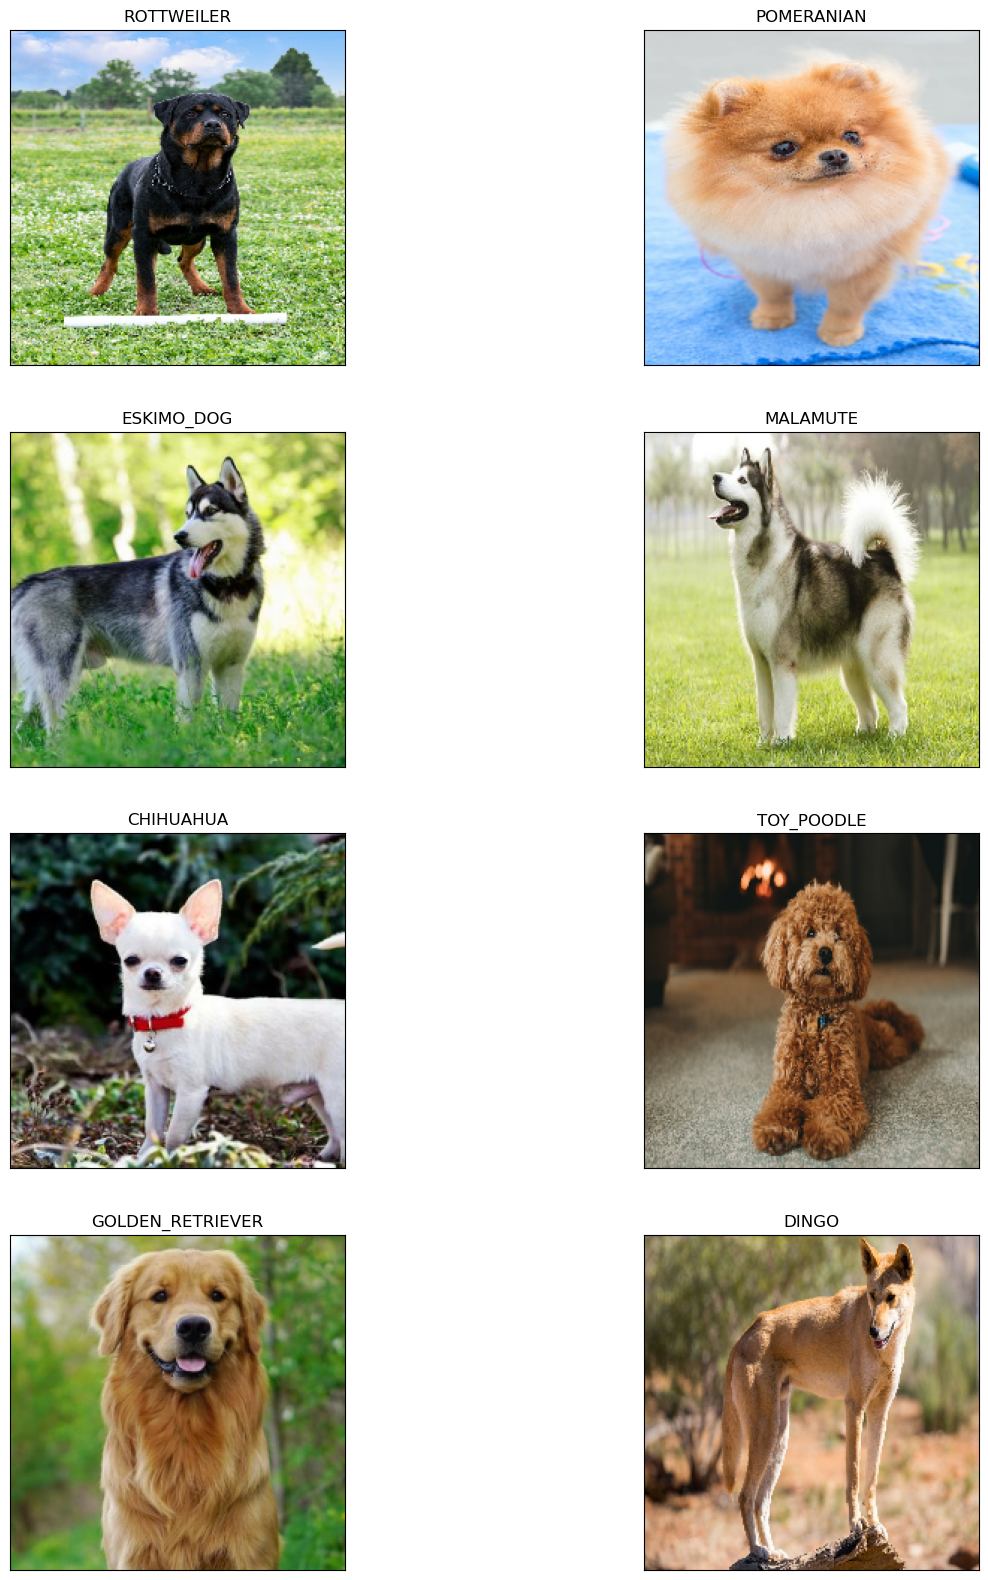

In [363]:
custom_image_prediction(image_dir="custom_dog_photos")